In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial
import os
import sys
import numpy as np
import jax
import jax.numpy as jnp
import diffrax as dfx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pink_palette = sns.cubehelix_palette(rot=0.5, start=2.7, gamma=1.1)

jax.config.update('jax_platform_name', 'cpu')


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from src.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics, get_true_interaction_cols
from src.utils.common.setup_new import construct_circuit_from_cfg, prepare_config
from explanations.data_enhancing import enhance_data, proc_info, melt, summ

In [3]:
og_dir = '../data/generate_seqs_flexible/2023_04_17_205800/'
fn_og = os.path.join(og_dir, 'circuit_stats.csv')
mut_dir = '../data/ensemble_mutation_effect_analysis/2023_05_16_174613/mutation_effect_on_interactions_signal'
fn_mut = '../data/ensemble_mutation_effect_analysis/2023_05_16_174613/summarise_simulation/tabulated_mutation_info.csv'

data = pd.read_csv(fn_mut)

In [4]:
data, num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols = proc_info(data)


/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/home/wadh6511/Kode/gene-circuit-glitch-prediction/explanations/data_enhancing.py:70: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  mutation_log = grouped[numerical_cols].apply(


In [5]:
# Mutation stats

good_cols = list(data.columns)
[good_cols.remove(x) for x in get_true_interaction_cols(data, 'binding_rates_dissociation') + get_true_interaction_cols(data, 'eqconstants') +
get_true_interaction_cols(data, 'energies') + get_true_interaction_cols(data, 'binding_sites') + num_group_cols + num_bs_cols]
# interaction = 'energies'
dfm = melt(data[data['sample_name'] == 'RNA_0'], num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols)
# dfm = data[data['sample_name'] == 'RNA_0'].melt(good_cols, value_vars=get_true_interaction_cols(
#     data, interaction), var_name='idx', value_name=interaction)

/home/wadh6511/Kode/gene-circuit-glitch-prediction/explanations/data_enhancing.py:121: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  infom[f'{k}_diffs'] = info.groupby(['circuit_name'])[get_true_interaction_cols2(info, k)].apply(
/home/wadh6511/Kode/gene-circuit-glitch-prediction/explanations/data_enhancing.py:123: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and

### Investigate gain of interaction mutations

For some reason there's a weird ranking in the mutation numbers

In [6]:
low_circs = dfm[(dfm['num_interacting'] == 2) & (dfm['num_self_interacting'] == 1) & (dfm['mutation_num'] == 0)]['circuit_name'].unique()

gain_dfm = dfm[dfm['circuit_name'].isin(low_circs) & (dfm['mutation_num'] > 0) & (dfm['num_interacting'] >= 2) & (dfm['num_self_interacting'] >= 1)]

Text(0, 0.5, 'Mean energy (kcal)')

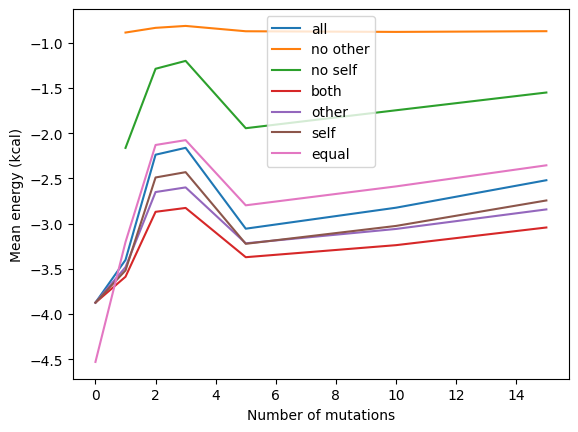

In [7]:
m = dfm.groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_no_other = dfm[dfm['num_interacting'] == 0].groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_no_self = dfm[dfm['num_self_interacting'] == 0].groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_both = dfm[(dfm['num_interacting'] > 0) & (dfm['num_self_interacting'] > 0)].groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_other = dfm[dfm['num_interacting'] > 0].groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_self = dfm[dfm['num_self_interacting'] > 0].groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_equal = dfm[dfm['num_self_interacting'] == dfm['num_interacting']].groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})

plt.figure()
sns.lineplot(m, x='mutation_num', y='energies', label='all')
sns.lineplot(m_no_other, x='mutation_num', y='energies', label='no other')
sns.lineplot(m_no_self, x='mutation_num', y='energies', label='no self')
sns.lineplot(m_both, x='mutation_num', y='energies', label='both')
sns.lineplot(m_other, x='mutation_num', y='energies', label='other')
sns.lineplot(m_self, x='mutation_num', y='energies', label='self')
sns.lineplot(m_equal, x='mutation_num', y='energies', label='equal')

plt.xlabel('Number of mutations')
plt.ylabel('Mean energy (kcal)')

Text(0.5, 0.98, 'Gain of interactions upon mutation')

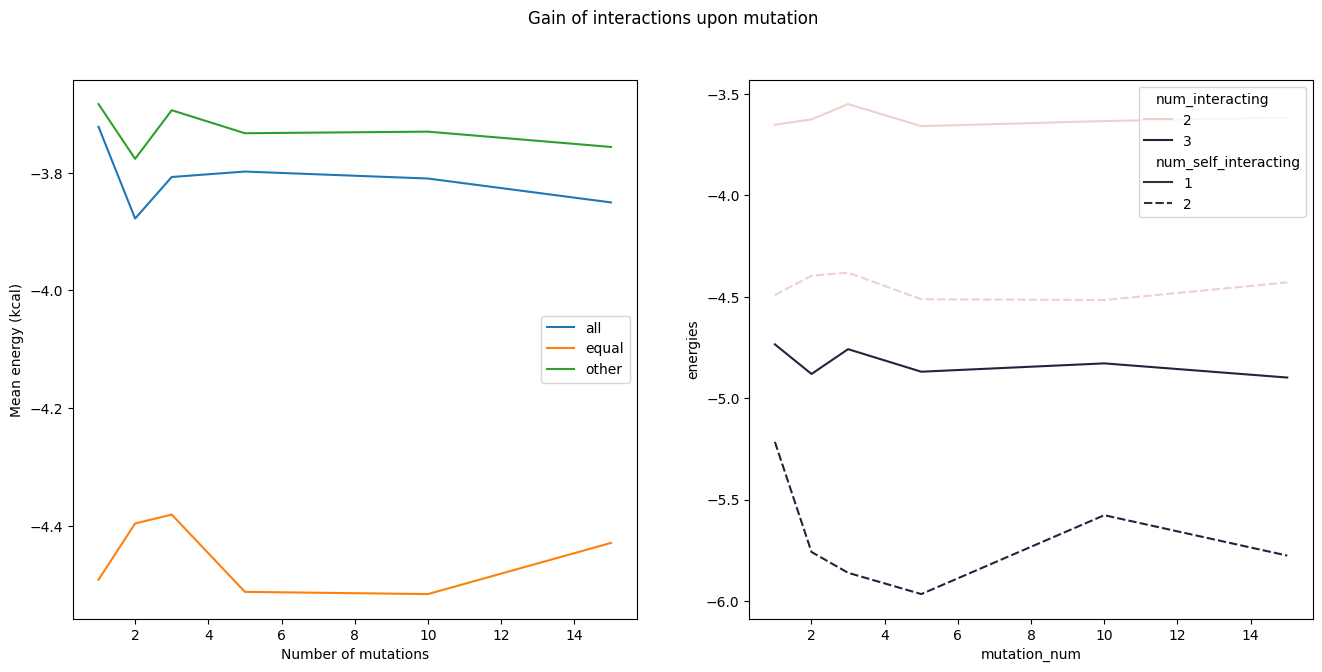

In [8]:
m = gain_dfm.groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_equal = gain_dfm[gain_dfm['num_interacting'] == gain_dfm['num_self_interacting']].groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_other = gain_dfm[gain_dfm['num_interacting'] > gain_dfm['num_self_interacting']].groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_self = gain_dfm[gain_dfm['num_self_interacting'] > gain_dfm['num_interacting']].groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})


plt.figure(figsize=(16,7))
ax = plt.subplot(1,2,1)
sns.lineplot(m, x='mutation_num', y='energies', label='all')
sns.lineplot(m_equal, x='mutation_num', y='energies', label='equal')
sns.lineplot(m_other, x='mutation_num', y='energies', label='other')
sns.lineplot(m_self, x='mutation_num', y='energies', label='self')

plt.xlabel('Number of mutations')
plt.ylabel('Mean energy (kcal)')

ax = plt.subplot(1,2,2)
m = gain_dfm.groupby(['mutation_num', 'num_interacting', 'num_self_interacting'], as_index=False).agg({'energies': 'mean'})
sns.lineplot(m, x='mutation_num', y='energies', hue='num_interacting', style='num_self_interacting')

plt.suptitle('Gain of interactions upon mutation')


In [9]:
dfm['bs_group_index'] = dfm['num_bs'].apply(lambda x: list(np.arange(len(x))))
dfm_e_bs = dfm.explode(column=['num_bs', 'bs_group_index'])

Text(0.5, 0, 'Number of binding site groups')

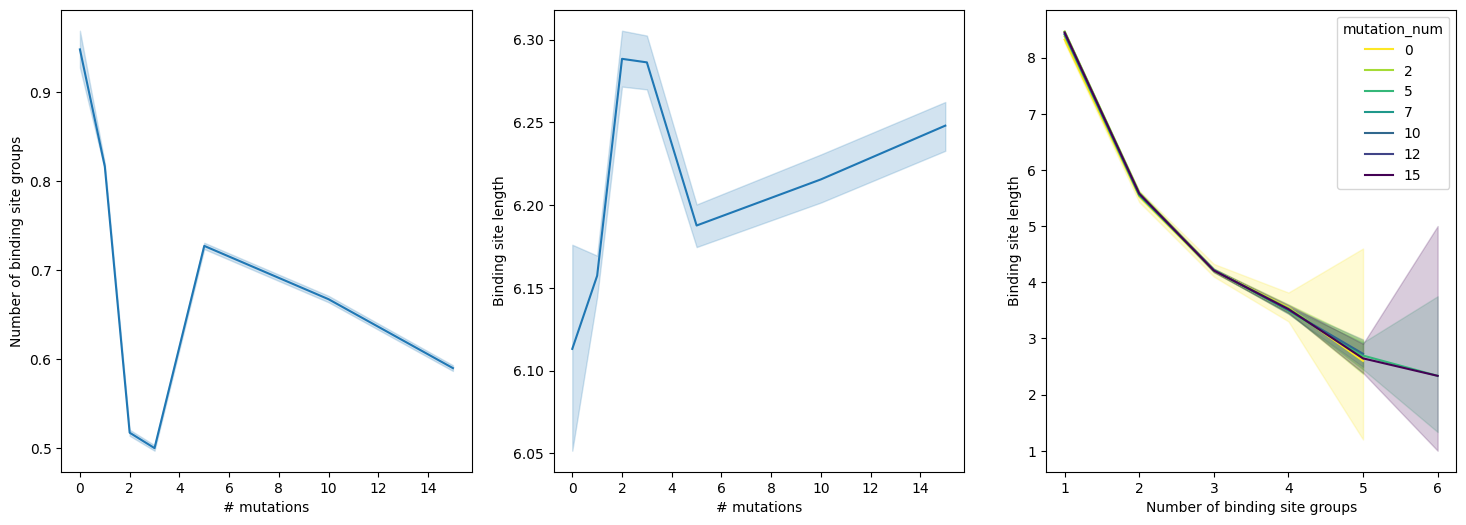

In [10]:
plt.figure(figsize=(18,6))
ax = plt.subplot(1,3,1)
sns.lineplot(dfm, x='mutation_num', y='num_groups')
plt.xlabel('# mutations')
plt.ylabel('Number of binding site groups')

ax = plt.subplot(1,3,2)
sns.lineplot(dfm_e_bs.reset_index(), x='mutation_num', y='num_bs')
plt.xlabel('# mutations')
plt.ylabel('Binding site length')

ax = plt.subplot(1,3,3)
sns.lineplot(dfm_e_bs.reset_index(), x='num_groups', y='num_bs', hue='mutation_num', palette='viridis_r')
plt.ylabel('Binding site length')
plt.xlabel('Number of binding site groups')



Text(0.5, 0, 'Binding site length')

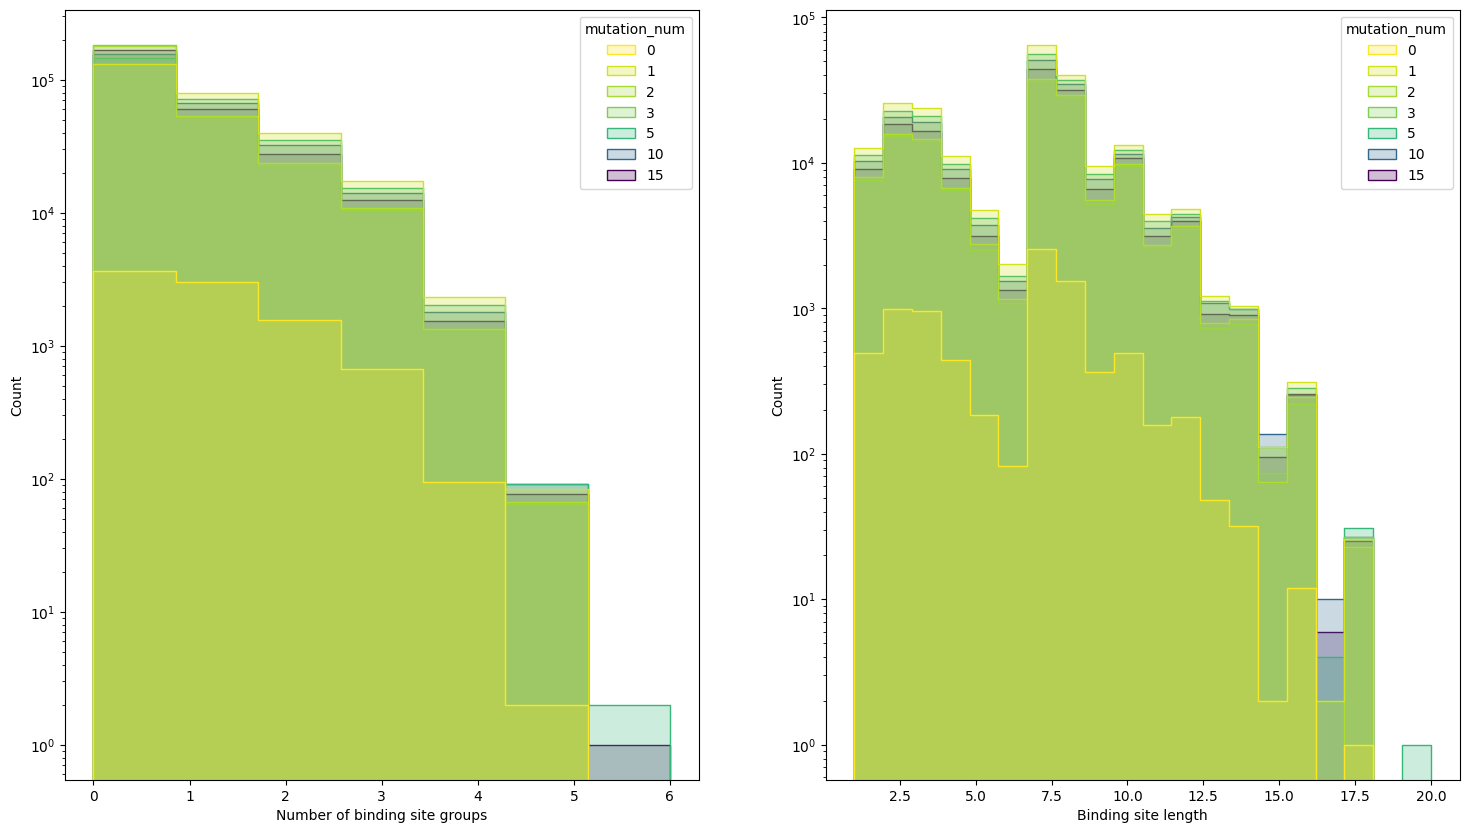

In [15]:
plt.figure(figsize=(18,10))
ax = plt.subplot(1,2,1)
sns.histplot(dfm, hue='mutation_num', x='num_groups', element='step', palette='viridis_r', bins = 7, log_scale=[False, True])
plt.xlabel('Number of binding site groups')

ax = plt.subplot(1,2,2)
sns.histplot(dfm_e_bs.reset_index(), hue='mutation_num', x='num_bs', palette='viridis_r', element='step', bins=20, log_scale=[False, True])
plt.xlabel('Binding site length')

Text(0, 0.5, 'Energies (kcal)')

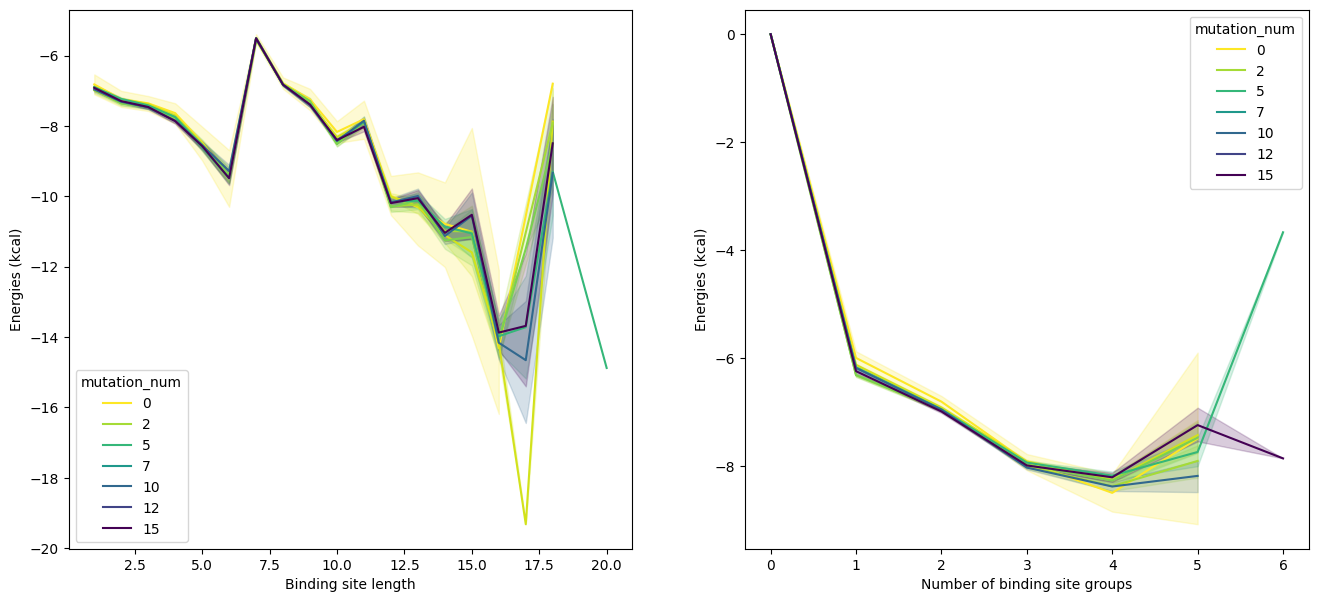

In [14]:
plt.figure(figsize=(16, 7))
ax = plt.subplot(1,2,1)
sns.lineplot(dfm_e_bs.reset_index(), x='num_bs', y='energies', hue='mutation_num', palette='viridis_r')
plt.xlabel('Binding site length')
plt.ylabel('Energies (kcal)')
ax = plt.subplot(1,2,2)
sns.lineplot(dfm_e_bs.reset_index(), x='num_groups', y='energies', hue='mutation_num', palette='viridis_r')
plt.xlabel('Number of binding site groups')
plt.ylabel('Energies (kcal)')